In [30]:
# noscript
!jupyter nbconvert --RegexRemovePreprocessor.patterns="['# ?noscript']" --TemplateExporter.exclude_markdown=True --to python compare_metrics_over_datasets.ipynb

[NbConvertApp] Converting notebook compare_metrics_over_datasets.ipynb to python
[NbConvertApp] Writing 5195 bytes to compare_metrics_over_datasets.py


In [2]:
import pandas
import numpy
import seaborn
import matplotlib.pyplot as plt

import openml

import sklearn.metrics
import sklearn.ensemble
import sklearn.svm
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.base
import sklearn.utils
import sklearn.linear_model
import sklearn.naive_bayes
import sklearn.neural_network

from ridgereliability import plots, metrics

import os
import multiprocessing
import logging
import time
from joblib import load, dump

In [ ]:
import argparse
parser = argparse.ArgumentParser()
parser.add_argument("--n-processes", type=int, required=True)
n_procs = parser.parse_args().n_processes

In [27]:
# noscript
n_procs = multiprocessing.cpu_count()

In [3]:
logging.basicConfig(level=logging.INFO)

In [4]:
numpy.random.seed(42)

# Compare metrics over datasets

In this notebook we collect calibration estimates for several models and datasets. The estimates are computed with the Expected Calibration Error (ECE), Balanced-ECE, and Posterior Expected Accuracy-based Calibration Error (PEACE).

Tested models:
- Random Forest
- SVM
- Logistic Regression
- Gaussian Naive Bayes
- MLP

Tested datasets (from Open ML):
- [eeg-eye-state](https://www.openml.org/d/1471), task [9983](https://www.openml.org/t/9983)
- [Phoneme](https://www.openml.org/d/1489), task [9952](https://www.openml.org/t/9952)
- [mozilla4](https://www.openml.org/d/1046), task [3899](https://www.openml.org/t/3899)
- [electricity](https://www.openml.org/d/151), task [219](https://www.openml.org/t/219)
- [Magic Telescope](https://www.openml.org/d/1120), task [3954](https://www.openml.org/t/3954)
- [artificial characters](https://www.openml.org/d/1459), task [14964](https://www.openml.org/t/14964)
- [pendigits](https://www.openml.org/d/32), task [32](https://www.openml.org/t/32)
- [letter](https://www.openml.org/d/6), task [6](https://www.openml.org/t/6)
- [JapaneseVowels](https://www.openml.org/d/375), task [3510](https://www.openml.org/t/3510)
- [glass](https://www.openml.org/d/41), task [40](https://www.openml.org/t/40)

## Datasets

First of all, we need to be able to load and preprocess multiple datasets appropriately to prepare it for classification. 
To this end we implement a function that will load a dataset and classification task from OpenML.

In [5]:
TASKS = [9983, 9952, 3899, 219, 3954, 14964, 32, 6, 3510, 40]

In [6]:
def load_openml_task(task_id):
    task = openml.tasks.get_task(task_id)
    X, y = task.get_X_and_y("dataframe")
    n_repeats, n_folds, n_samples = task.get_split_dimensions()

    folds = numpy.empty((len(X)), dtype=int)
    for fold_idx in range(n_folds):
        _, test_indices = task.get_train_test_split_indices(
            repeat=0,
            fold=fold_idx,
            sample=0,
        )
        
        folds[test_indices] = fold_idx
        
    splitter = sklearn.model_selection.PredefinedSplit(folds)
                
    return X, y, splitter        

In [7]:
# noscript
X, y, splitter = load_openml_task(9952)

DEBUG:openml.datasets.dataset:Data pickle file already exists and is up to date.
DEBUG:openml.datasets.dataset:Data pickle file already exists and is up to date.


In [8]:
# noscript
for train_idx, test_idx in splitter.split():
    print(test_idx.shape)

(541,)
(541,)
(541,)
(541,)
(540,)
(540,)
(540,)
(540,)
(540,)
(540,)


## Getting calibration metrics

For each dataset we fit and evaluate multiple models. We record calibration metrics (ECE, ECE-balanced, PEACE), and some performance metrics (balanced accuracy, F1-score, accuracy). To this end we implement a function that runs this procedure for one model on one OpenML task.

In [9]:
MODELS = {
    "rf": sklearn.ensemble.RandomForestClassifier(),
    "svm": sklearn.svm.SVC(probability=True),
    "logreg": sklearn.linear_model.LogisticRegression(),
    "nb": sklearn.naive_bayes.GaussianNB(),
    "mlp": sklearn.neural_network.MLPClassifier()
}

In [10]:
def get_fold_metrics_for_model(row, Xt, yt, Xv, yv):

    # get and fit fresh model
    model = sklearn.base.clone(MODELS[row["model_id"]])
    model.fit(Xt, yt)

    # compute metrics on test data
    y_probs = model.predict_proba(Xv)
    y_probs_max = y_probs.max(axis=1)
    y_preds = model.predict(Xv)
    y_test = yv

    bins = 15
    row.update({
        "accuracy": sklearn.metrics.accuracy_score(y_test, y_preds),
        "balanced_accuracy": sklearn.metrics.balanced_accuracy_score(y_test, y_preds),
        "f1": sklearn.metrics.f1_score(y_test, y_preds, average="weighted"),
        'ece': metrics.ece(y_probs_max, y_preds, y_test, bins=bins),
        'ece_balanced': metrics.ece(y_probs_max, y_preds, y_test, balanced=True, bins=bins),
        'peace': metrics.peace(y_probs_max, y_preds, y_test, bins=bins),
        'class_wise_ece': metrics.class_wise_error(y_probs, y_preds, y_test, metrics.ece, bins=bins),
        'class_wise_peace': metrics.class_wise_error(y_probs, y_preds, y_test, metrics.peace, bins=bins)
    })
    
    return row

In [11]:
def get_cv_metrics_for_model_and_task(model_id, task_id, pool, n_repeats):
    
    X, y, splitter = load_openml_task(task_id) # repeated runs will use cached data
    
    promises = []
    for i, (train_idx, test_idx) in enumerate(splitter.split()):
        for j in range(n_repeats):
            row = {
                "fold": i,
                "repeat": j,
                "model_id": model_id,
                "task_id": task_id,
            }

            # split data
            Xt, yt = X.iloc[train_idx], y.iloc[train_idx]
            Xv, yv = X.iloc[test_idx], y.iloc[test_idx]

            promise = pool.apply_async(
                get_fold_metrics_for_model,
                (row, Xt, yt, Xv, yv)
            )
            promises.append(promise)
        
    return promises

## Data collection over all datasets and models

In [12]:
with multiprocessing.Pool(processes=n_procs) as pool:
    
    output_file = f"metrics_{int(time.time())}.dat"
    logging.info(f"Output to {output_file}")
    
    promises = []
    for model_id in MODELS.keys():
        for task_id in TASKS:
            promises.extend(get_cv_metrics_for_model_and_task(model_id, task_id, pool, 1))
            
    data = []
    for promise in promises:
        data.append(promise.get())
        logging.info(f"Finished promises: {len(data)}/{len(promises)} ({len(data)/len(promises)*100:.2f}%)")
        df = pandas.DataFrame(data)
        dump(df, output_file)

INFO:root:Output to metrics_1600886418.dat
DEBUG:openml.datasets.dataset:Data pickle file already exists and is up to date.
DEBUG:openml.datasets.dataset:Data pickle file already exists and is up to date.
DEBUG:openml.datasets.dataset:Data pickle file already exists and is up to date.
DEBUG:openml.datasets.dataset:Data pickle file already exists and is up to date.
DEBUG:openml.datasets.dataset:Data pickle file already exists and is up to date.
DEBUG:openml.datasets.dataset:Data pickle file already exists and is up to date.
DEBUG:openml.datasets.dataset:Data pickle file already exists and is up to date.
DEBUG:openml.datasets.dataset:Data pickle file already exists and is up to date.
DEBUG:openml.datasets.dataset:Data pickle file already exists and is up to date.
DEBUG:openml.datasets.dataset:Data pickle file already exists and is up to date.
INFO:openml.datasets.dataset:Going to remove the following attributes: ['ID']
DEBUG:openml.datasets.dataset:Data pickle file already exists and is 

KeyboardInterrupt: 

In [ ]:
exit()

# Analysis

In [13]:
df = load("metrics_1600886418.dat")

In [14]:
grouped_df = df.groupby(["model_id", "task_id", "repeat"]).aggregate("mean").drop(columns=["fold"]).reset_index()

In [15]:
grouped_df

,model_id,task_id,repeat,accuracy,balanced_accuracy,f1,ece,ece_balanced,peace,class_wise_ece,class_wise_peace
0,rf,32,0,0.989545,0.989564,0.989548,0.050014,0.052695,0.020030,0.056072,0.044744
1,rf,219,0,0.910642,0.906696,0.910458,0.054522,0.053303,0.051162,0.057114,0.055451
2,rf,3899,0,0.954840,0.935529,0.954147,0.014922,0.068852,0.066079,0.019247,0.022184
3,rf,3954,0,0.880284,0.854851,0.878305,0.033174,0.028275,0.035690,0.044080,0.048750
4,rf,9952,0,0.913404,0.891190,0.912982,0.051640,0.059560,0.062919,0.074721,0.076231
5,rf,9983,0,0.932844,0.929976,0.932666,0.125236,0.124996,0.111944,0.130183,0.118189
6,rf,14964,0,0.945976,0.944177,0.945920,0.131178,0.134773,0.088994,0.155636,0.123464


In [22]:
dfs = []
for col in grouped_df.iloc[:, 3:]:
    dfs.append(
        pandas.DataFrame(
            dict(value=grouped_df[col], metric=col, subject=grouped_df["model_id"] + grouped_df["task_id"].astype(str))
        )
    )
long_df = pandas.concat(dfs)

In [23]:
long_df.head()

,value,metric,subject
0,0.989545,accuracy,rf32
1,0.910642,accuracy,rf219
2,0.954840,accuracy,rf3899
3,0.880284,accuracy,rf3954
4,0.913404,accuracy,rf9952


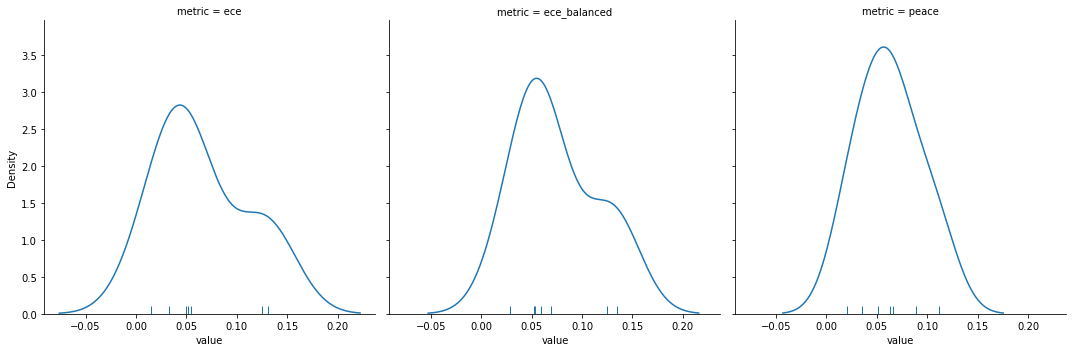

In [24]:
seaborn.displot(data=long_df[long_df["metric"].isin(["ece", "ece_balanced", "peace"])], x="value", col="metric", rug=True, kind="kde")

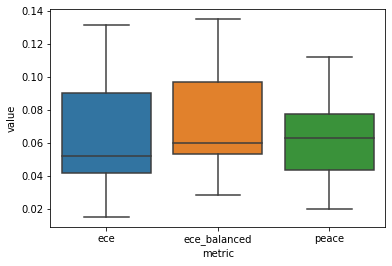

In [25]:
seaborn.boxplot(data=long_df[long_df["metric"].isin(["ece", "ece_balanced", "peace"])], y="value", x="metric")

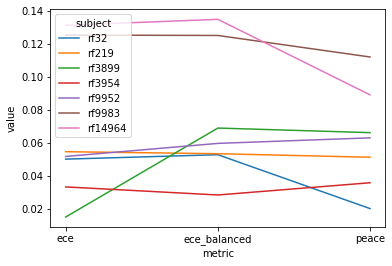

In [26]:
seaborn.lineplot(data=long_df[long_df["metric"].isin(["ece", "ece_balanced", "peace"])], y="value", x="metric", hue="subject", err_style="bars", palette="tab10")